In [1]:
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import os, sys, re, gc, glob
from tqdm.auto import tqdm, trange
from utils import JDIDataset, JDIModel, get_grey_image, assign_labels, accuracy

import seaborn as sns

2021-05-28 15:44:07,859 -INFO - config:config.py:16 - Module utils.config was loaded
2021-05-28 15:44:07,862 -INFO - common:common.py:569 - Module utils.common is loaded...
2021-05-28 15:44:07,876 -INFO - dataset_builder:dataset_builder.py:200 - dataset package is loaded...
2021-05-28 15:44:07,963 -INFO - dataset:dataset.py:647 - dataset package is loaded...


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
DEVICE='cpu'

In [4]:
model = torch.load('model/model.pth').to(DEVICE)
model.eval()

JDIModel(
  (input_layer): Linear(in_features=5628, out_features=128, bias=False)
  (batchNorm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden1): Linear(in_features=128, out_features=32, bias=False)
  (batchNorm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.1, inplace=True)
  (hidden2): Linear(in_features=32, out_features=22, bias=True)
)

## Load test dataset

In [5]:
dataset_name = 'complex-table'


In [6]:
dataset = JDIDataset(dataset_names=[dataset_name], rebalance=False)

2021-05-28 15:44:24,994 -INFO - dataset:dataset.py:246 - List of dataset_names:['complex-table']
2021-05-28 15:44:24,994 -INFO - dataset:dataset.py:252 - Dataset for complex-table
2021-05-28 15:44:26,404 -INFO - dataset:dataset.py:254 - Dataset shape: (426, 13)
2021-05-28 15:44:26,407 -INFO - dataset:dataset.py:256 - cleaning tag_name from dummy/auxiliary words
2021-05-28 15:44:26,409 -INFO - dataset:dataset.py:47 - select all leafs (nodes which are not parents)
2021-05-28 15:44:26,409 -INFO - dataset:dataset.py:50 - Leafs set size: 206 (nodes which have no children)
2021-05-28 15:44:26,410 -INFO - dataset:dataset.py:53 - count number of references to leafs
2021-05-28 15:44:26,412 -INFO - dataset:dataset.py:57 - Nodes with leafs as children set size: 131 (nodes which have leafs as children)
2021-05-28 15:44:26,414 -INFO - dataset:dataset.py:60 - count num children for each node
2021-05-28 15:44:26,414 -INFO - dataset:dataset.py:62 - Nodes with children: 221
2021-05-28 15:44:26,416 -INF

  0%|          | 0/426 [00:00<?, ?it/s]

2021-05-28 15:44:28,505 -INFO - dataset:dataset.py:273 - Dataset shape after merging with parents: (426, 44)
2021-05-28 15:44:28,505 -WARNING - dataset:dataset.py:279 - Load LABELS from dataset/annotations/complex-table.txt


Assigning labels:   0%|          | 0/72 [00:00<?, ?it/s]

2021-05-28 15:44:28,863 -INFO - dataset:dataset.py:295 - Concatenate datasets
2021-05-28 15:44:28,866 -INFO - dataset:dataset.py:297 - Dataset shape after reading: (434, 47)
2021-05-28 15:44:28,870 -WARNING - dataset:dataset.py:627 - Loading count vectorizer for column "cv_class": model/count_vectorizer_class.pkl
2021-05-28 15:44:29,023 -INFO - dataset:dataset.py:644 - class_sm: (434, 1081)
2021-05-28 15:44:29,026 -INFO - dataset:dataset.py:306 - Build OHE column for attribute role
2021-05-28 15:44:29,028 -INFO - dataset:dataset.py:306 - Build OHE column for attribute type
2021-05-28 15:44:29,030 -INFO - dataset:dataset.py:306 - Build OHE column for attribute ui
2021-05-28 15:44:29,032 -INFO - dataset:dataset.py:311 - Build OHE column for attribute role_parent
2021-05-28 15:44:29,032 -INFO - dataset:dataset.py:311 - Build OHE column for attribute type_parent
2021-05-28 15:44:29,036 -INFO - dataset:dataset.py:311 - Build OHE column for attribute ui_parent
2021-05-28 15:44:29,039 -INFO -

In [7]:
dataset.dataset.shape

(434, 56)

In [8]:
dataset.labels

0       n/a
1       n/a
2       n/a
3       n/a
4       n/a
       ... 
421     n/a
422     n/a
423     n/a
424    link
425    link
Name: label, Length: 434, dtype: object

In [9]:
dataset.dataset.label

0      21
1      21
2      21
3      21
4      21
       ..
421    21
422    21
423    21
424     1
425     1
Name: label, Length: 434, dtype: int32

In [10]:
dataloader=DataLoader(dataset, shuffle=False, batch_size=1, collate_fn=dataset.collate_fn, pin_memory=True)

In [11]:
results = []
softmax = torch.nn.Softmax(dim=1)
with trange(len(dataloader)) as bar:
    with torch.no_grad():
        for x, y in dataloader:
           
            y_pred = softmax(model(x.to(DEVICE))) # get prediction logits, and convert them to probabilities
            # print(y_pred.__repr__())
                                                   
            y_prob = y_pred.to('cpu').detach().numpy()
            y_pred = y_prob[0].argmax()
            
            y_prob = y_prob[0, y_pred].item()
            y = y.item()           
            
            results.append({
                'y_true': y,
                'y_pred': y_pred,
                'y_probability': y_prob,
                'y_true_label': dataset.classes_reverse_dict[y], 
                'y_pred_label': dataset.classes_reverse_dict[y_pred]
            })
            bar.update(1)

results_df = pd.DataFrame(results)


  0%|          | 0/434 [00:00<?, ?it/s]

In [12]:
list(dataset.classes_dict.keys())

['button',
 'link',
 'iframe',
 'textfield',
 'dropdown',
 'checkbox_btn',
 'checkbox_label',
 'radiobutton_btn',
 'radiobutton_label',
 'textarea',
 'text',
 'fileinput',
 'image',
 'colorpicker',
 'range',
 'progressbar',
 'datetimeselector',
 'numberselector',
 'dropdownselector',
 'checklist',
 'table',
 'n/a']

In [13]:
r_df = results_df[~((results_df.y_true_label == 'n/a') & (results_df.y_pred_label == 'n/a'))]

confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y_true=r_df.y_true_label.values,
                     y_pred=r_df.y_pred_label.values, 
                     labels=list(dataset.classes_dict.keys())
                    ), 
    columns=list(dataset.classes_dict.keys()),
    index=list(dataset.classes_dict.keys())
)



In [14]:
confusion_matrix_df

,button,link,iframe,textfield,dropdown,checkbox_btn,checkbox_label,radiobutton_btn,radiobutton_label,textarea,...,image,colorpicker,range,progressbar,datetimeselector,numberselector,dropdownselector,checklist,table,n/a
button,3,5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
link,0,41,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
iframe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
textfield,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dropdown,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
checkbox_btn,0,0,0,0,0,0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
checkbox_label,0,3,0,0,0,0,8,0,0,0,...,0,0,0,0,0,0,0,0,0,0
radiobutton_btn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
radiobutton_label,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
textarea,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
import seaborn as sns


<AxesSubplot:>

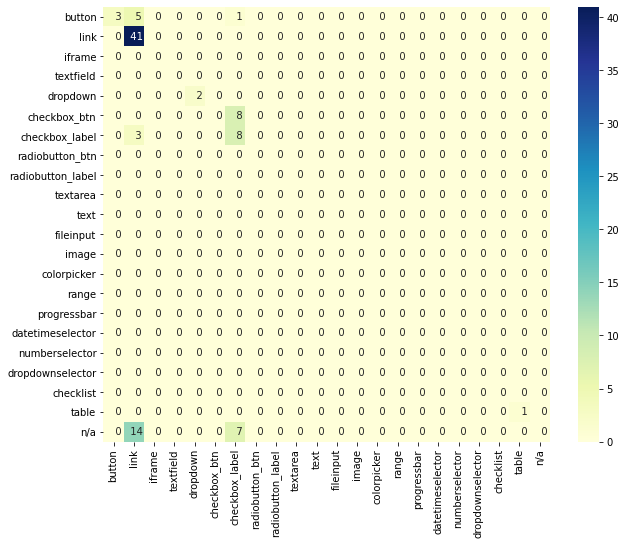

In [16]:
plt.figure(figsize=(10,8))
display(sns.heatmap(confusion_matrix_df, annot=True, fmt="4d", cmap="YlGnBu"));
plt.show()
#display(sns.heatmap(confusion_matrix_df[:-1][confusion_matrix_df.columns[:-1]], annot=True, fmt="4d", cmap="YlGnBu"));
#plt.show();


In [17]:
dataset_name

'complex-table'

In [18]:
accuracy(results_df)

2021-05-28 15:45:04,203 -INFO - common:common.py:438 - Accuracy:  55/93 = 0.5913978494623656, for 434 elements


0.5913978494623656

In [19]:
dataset.classes_dict

{'button': 0,
 'link': 1,
 'iframe': 2,
 'textfield': 3,
 'dropdown': 4,
 'checkbox_btn': 5,
 'checkbox_label': 6,
 'radiobutton_btn': 7,
 'radiobutton_label': 8,
 'textarea': 9,
 'text': 10,
 'fileinput': 11,
 'image': 12,
 'colorpicker': 13,
 'range': 14,
 'progressbar': 15,
 'datetimeselector': 16,
 'numberselector': 17,
 'dropdownselector': 18,
 'checklist': 19,
 'table': 20,
 'n/a': 21}

In [20]:

dataset.dataset['label_text_predicted'] = results_df.y_pred_label
dataset.dataset['probability'] = results_df.y_probability


(867, 1200)


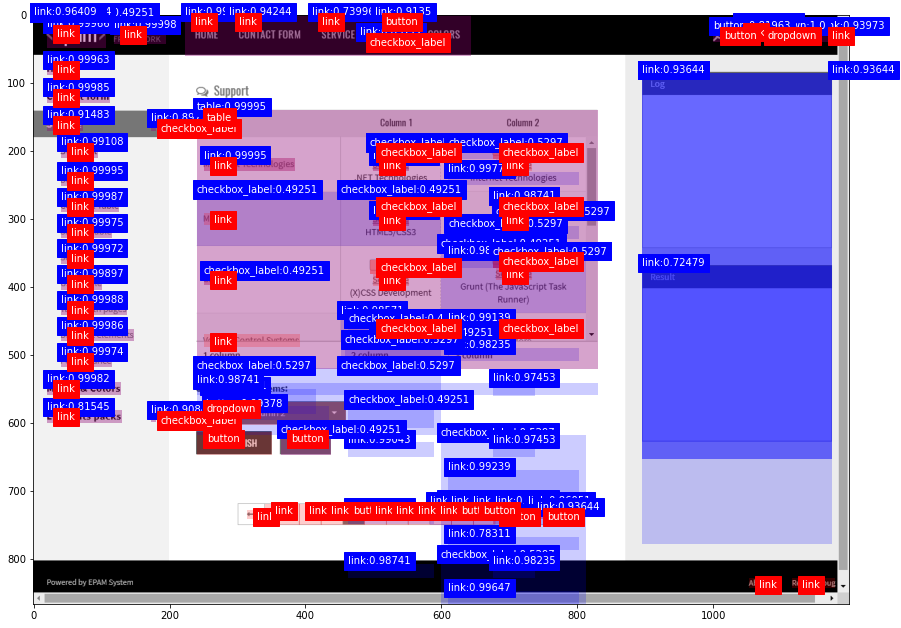

In [21]:
gray_img = get_grey_image(f'dataset/images/{dataset_name}.png')
print(gray_img.shape)

IMG_SIZE = 15
_h = gray_img.shape[0]/gray_img.shape[1]*IMG_SIZE
_w = IMG_SIZE
plt.figure(figsize=(_w, _h))

plt.imshow(gray_img, cmap='gray')
axes = plt.gca()

for i, r in dataset.dataset[dataset.dataset.label_text_predicted != 'n/a'].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    
    if (r.x<0) or (r.y<0): # or (r.x>r.width): #or (r.y>r.height):
        continue
        
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'blue')
    axes.add_patch(patch)
    axes.text(r.x, r.y, r.label_text_predicted+':'+str(round(r.probability, 5)), color='white', backgroundcolor='blue')

for i, r in dataset.dataset[dataset.dataset.label != dataset.dummy_class_value].iterrows():
    #print(r.predicted_label, r.x, r.y, r.width, r.height)
    patch = Rectangle((r.x, r.y), r.width, r.height, linewidth=2, alpha = .2, facecolor = 'red')
    axes.add_patch(patch)
    axes.text(r.x+15, r.y+15, dataset.classes_reverse_dict[r.label], color='white', backgroundcolor='red')
    




In [ ]:
results_df

In [ ]:
dataset.dataset[:1].to_json(orient='records')

In [ ]:
dataset.dataset.columns